In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
none_df = pd.read_json("outputs/none_1/logs.json")
base_df = pd.read_json("outputs/base_1/logs.json")
mean_df = pd.read_json("outputs/mean_1/logs.json")
dist_df = pd.read_json("outputs/dist_1/logs.json")
def plot(key, start=10):
    _, ax = plt.subplots(1, 1)
    ax.set_ylabel(key)
    none_df[none_df.index >= start][key].plot(ax=ax, label="none")
    base_df[base_df.index >= start][key].plot(ax=ax, label="base")
    mean_df[mean_df.index >= start][key].plot(ax=ax, label="mean")
    dist_df[dist_df.index >= start][key].plot(ax=ax, label="dist")
    ax.legend()

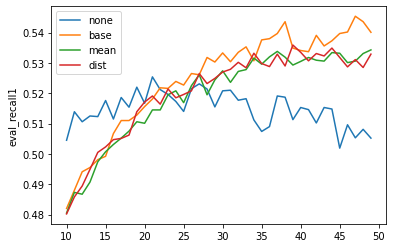

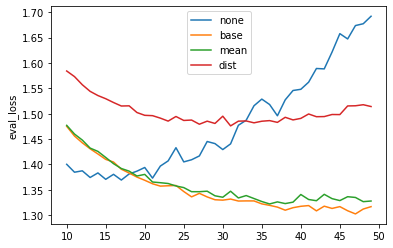

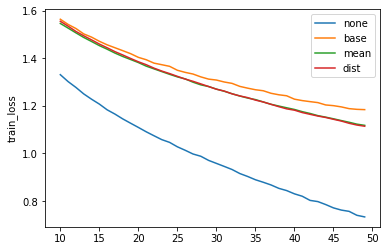

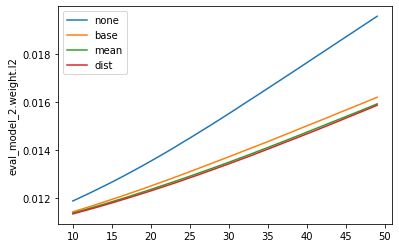

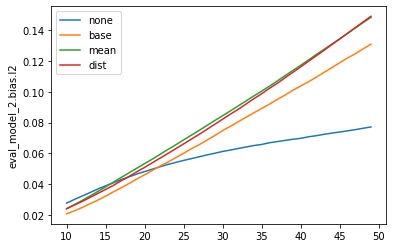

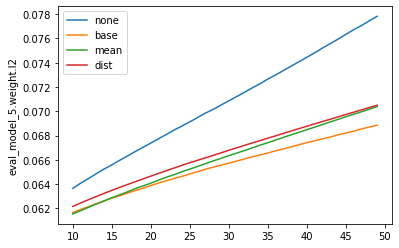

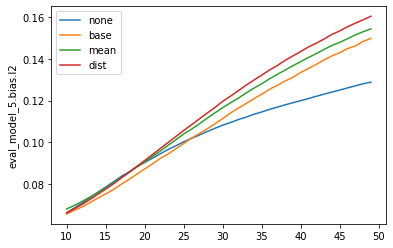

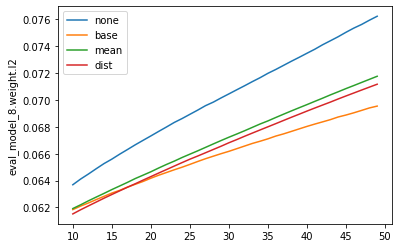

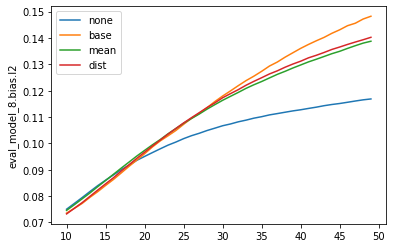

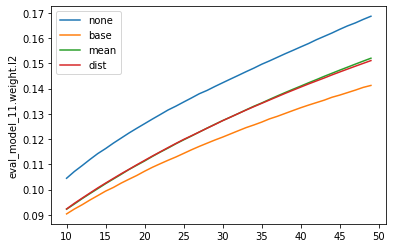

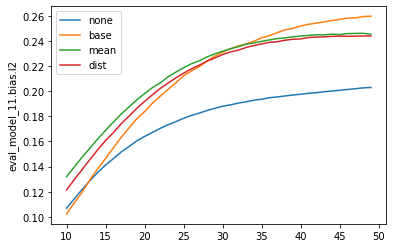

In [7]:
plot(f"eval_recall1")
plot(f"eval_loss")
plot(f"train_loss")
for i in (2,5,8,11):
    plot(f"eval_model_{i}.weight.l2")
    plot(f"eval_model_{i}.bias.l2")